**CÓDIGO 12: Ecuación de Schrodinger Independiente del Tiempo en 3D: El átomo de Hidrógeno.**

In [2]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

-Construcción del potencial

In [3]:
#Definimos el número de nodos y generamos la malla tridimensional
N = 120
X, Y, Z = np.mgrid[-25:25:N*1j, -25:25:N*1j, -25:25:N*1j]  
#Se genera una malla tridimensional NxNxN entre -25 y 25 (25 es elevado en el contexto del átomo de Bohr)

#Está en unidades del átomo de Bohr a0
#Tomar un radio de Bohr elevado me garantiza que pueda establecer que en la frontera de mi dominio la función de onda sea 0
#Esto es porque la función de onda del estado fundamental del átomo de hidrógeno tiende exponencialmente a cero al alejarse del núcleo
#(Análogo al por qué multiplicabamos por el factor 1000 el potencial en 1D)

h = np.diff(X[:,0,0])[0] #paso de la malla tridimensional en dimensiones de a0

#Definimos el potencial Vtilda=mh^2V

def Vtilda(x,y,z):
    return -h**2/np.sqrt(x**2 + y**2 + z**2 + 1e-10)

V=Vtilda(X,Y,Z)

#Se ha añadido 1e-10 en r puesto que en el origen el potencial se diverge,
#añadiendo este pequeño valor conseguimos que el potencial no tienda a infinito y es una buena aproximación


-Construcción de la matriz hamiltoniana y cálculo de autovectores y autovalores.

In [4]:
#Construimos la matriz D' a la que operaré con el producto de Kronecker. Análogo a 2D pero en 3D

diag= np.ones([N]) #Vector de 1s repetido dimensión N
diags=np.array([diag,-2*diag,diag]) #Vector de 1s -2s y 1s
D=sparse.spdiags(diags,np.array([-1,0,1]),N,N)
#La construcción de D' consiste en poner el vector diag en la posición -1 es decir en la diagonal inferior
#0 representa la posición de la diagonal principal (el vector -2*diags se coloca en la principal) y 1 la diagonal superior.
#Una sparse matrix es una matriz donde la mayoría de elementos son nulos y es útil utilizarla para almacenar y operar
#con sistemas grandes de ecuaciones pues sólamente almacenan los elementos no nulos.

#Construcción de la matriz cinética T y energía potencial U

T=-1/2*sparse.kronsum(sparse.kronsum(D,D),D) 
U=sparse.diags(V.reshape(N**3),(0))

H=T+U #Matriz de tamaño N^3 x N^3

H.shape #dimensión

(1728000, 1728000)

Como podemos apreciar, la dimensión de la matriz es realmente grande para poder operar eficientemente en el sentido computacional, por ello utilizamos PyTorch que permite trabajar en la GPU en lugar de la CPU como se ha hecho hasta ahora. Para hacer esta transformación pasamos de sparce matrix en la CPU a su análogo torch sparse tensor en el GPU (es su análogo).

In [5]:
# Convertimos la matriz dispersa a formato COO
H = H.tocoo()

# Extraemos índices y valores como arrays de NumPy
indices = np.array([H.row, H.col])          # Shape (2, NNZ)
values = np.array(H.data)                   # Shape (NNZ,)

# Creamos tensores de PyTorch
indices_tensor = torch.tensor(indices, dtype=torch.int64)
values_tensor = torch.tensor(values, dtype=torch.float32)

# Creamos el tensor disperso de PyTorch y lo movemos al dispositivo (CPU o GPU)
H_torch = torch.sparse_coo_tensor(indices=indices_tensor,
                                  values=values_tensor,
                                  size=H.shape).to(device)


autovalores, autovectores = lobpcg(H_torch, k=20, largest=False)

-Gráfica de las densidades de probabilidad

In [11]:
verts, faces, _, _ = measure.marching_cubes(autofunciones(5)**2, 1e-6, spacing=(0.1, 0.1, 0.1))
intensity = np.linalg.norm(verts, axis=1)

fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2], 
                                i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                intensity=intensity,
                                colorscale='Agsunset',
                                opacity=0.5)])

fig.update_layout(scene=dict(xaxis=dict(visible=False),
                              yaxis=dict(visible=False),
                              zaxis=dict(visible=False),
                              bgcolor='rgb(0, 0, 0)'),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

-Cálculo de los autovalores/energías propias

Los autovalores que se han obtenido son realmente $mh^2E$. Para obtener los reales, en primer lugar insertamos $\hbar$ y se tiene que $mh^2E/\hbar^2$. Ahora por otro lado, hemos establecido que el paso $h$ está en unidades del radio de Bohr $a_0$ por tanto insertamos $a_0$ en la expresión, $m(ah)^2E/\hbar^2$. Despejando $E$ se tiene que:
$E=\frac{\hbar^2}{mh^2a_0^2}$

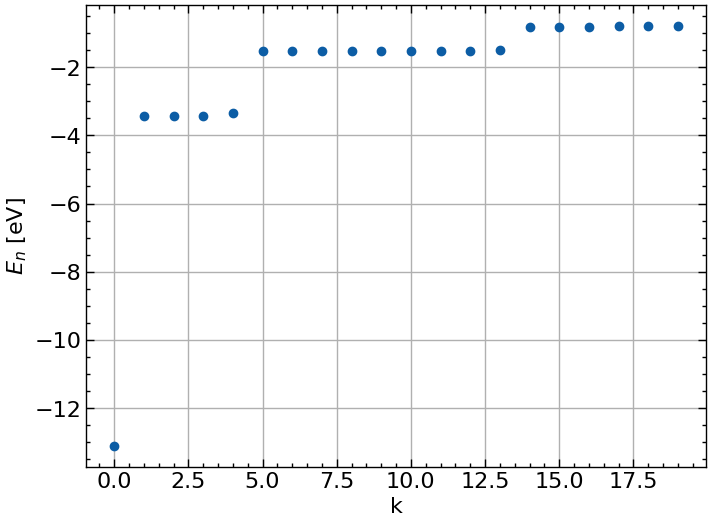

tensor([-13.0998,  -3.4222,  -3.4221,  -3.4219,  -3.3567,  -1.5136,  -1.5119,
         -1.5127,  -1.5133,  -1.5122,  -1.5114,  -1.5144,  -1.5135,  -1.4948,
         -0.8263,  -0.8105,  -0.8081,  -0.8052,  -0.7932,  -0.7802])


In [26]:
#Representamos los autovalores
hbar = 1.055e-34
a0=5.29e-11
m=9.11e-31
J_to_eV = 6.242e18
conversion = hbar**2 / m / h**2 / a0**2 * J_to_eV

plt.plot(autovalores.cpu()*conversion, 'o')
plt.xlabel('k')
plt.ylabel('$E_n$ [eV]')
plt.grid()
plt.show()

print(autovalores.cpu()*conversion)
